# Rule-Based Lexical Diversity Analysis

In this notebook, we evaluate lexical richness metrics (TTR, RTTR, CTTR, MTLD, HDD, Entropy) on pre- and post-ChatGPT news sentences. 
We also implement simple rule-based thresholds to classify text as pre/post and analyze the results quantitatively and qualitatively.


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
from math import comb



# Loader Function: `load_txt_lines`

This function reads each file line by line and collects non-empty sentences.  

**Key points:**
- Strips whitespace to remove empty padding.
- Ignores lines that are empty to avoid introducing blank samples.  

Check the first few sentences of your dataset to ensure the loader correctly extracts content without losing lines.


In [2]:
def load_txt_lines(filepath):

    sentences = []
    with open(filepath, "r", encoding="utf-8", errors="ignore") as f:
        for line in f:
            line = line.strip()
            if line: 
                sentences.append(line)
    return sentences



We define a function load_txt_lines that reads a text file line by line and stores non-empty lines in a list. This ensures that blank lines or improperly formatted lines do not affect downstream analysis.

We then specify file paths for pre_rule_all.txt (pre-ChatGPT texts) and post_rule_all.txt (post-ChatGPT texts), and use load_dataset to combine them into a single DataFrame. Each text is labeled as 0 (pre) or 1 (post).

The resulting dataset can be seen via df.head(), and df.shape confirms the total number of sentences and columns. This structured dataset forms the basis for computing lexical richness metrics and building rule-based classifiers.

Combining the datasets with labels allows for supervised analysis, even when using rules instead of trained models.


In [3]:
pre_files = [
    r"pre_rule_all.txt"
]

post_files = [
    r"post_rule_all.txt"
]

def load_dataset(pre_files, post_files):
    texts = []
    labels = []

    # Pre-ChatGPT (0)
    for f in pre_files:
        t = load_txt_lines(f)
        texts.extend(t)
        labels.extend([0] * len(t))

    # Post-ChatGPT (1)
    for f in post_files:
        t = load_txt_lines(f)
        texts.extend(t)
        labels.extend([1] * len(t))

    df = pd.DataFrame({"text": texts, "label": labels})
    return df

df = load_dataset(pre_files, post_files)
print(df.head())
print(df.shape)


                                                text  label
0  "007's car of the moment is often pursued by a...      0
1  "102 -- that number is out of service," said o...      0
2  $110 million to fix central park section far f...      0
3  '11 august, that is the day it appears mr sylv...      0
4  $1.45m mpls. home designed by team behind swed...      0
(400000, 2)


We implement multiple measures of lexical diversity:

TTR (Type-Token Ratio): ratio of unique words to total words.

Root TTR: normalizes TTR by square root of token count, mitigating bias in longer texts.

Corrected TTR: alternative normalization to reduce text-length effect.

Entropy: measures unpredictability of token distribution in a text.

HDD (Hypergeometric Distribution Diversity): estimates probability of observing a type in a random sample, robust to text length.

MTLD (Measure of Textual Lexical Diversity): tracks the length of segments where TTR falls below a threshold.

Decision: We avoid removing punctuation, numbers, or stopwords, as these features may carry discriminative patterns in pre/post ChatGPT texts. Each metric captures slightly different aspects of lexical richness.

Guidance for Analysis: Compare metric distributions between pre and post datasets to identify which features provide the clearest separation. KDE plots or histograms are useful here.

In [11]:
def tokenize(text):
    return text.split()

def ttr(text):
    tokens = tokenize(text)
    if len(tokens) == 0:
        return 0
    return len(set(tokens)) / len(tokens)

def root_ttr(text):
    tokens = tokenize(text)
    if len(tokens) == 0:
        return 0
    return len(set(tokens)) / np.sqrt(len(tokens))

def corrected_ttr(text):
    tokens = tokenize(text)
    if len(tokens) == 0:
        return 0
    return len(set(tokens)) / np.sqrt(2 * len(tokens))

def entropy(text):
    tokens = tokenize(text)
    total = len(tokens)
    if total == 0:
        return 0
    counts = Counter(tokens)
    return -sum((c/total) * np.log2(c/total) for c in counts.values() if c > 0)

HD - D computation

In [12]:
from math import comb

def hdd(text, sample_size=42):
    tokens = tokenize(text)
    types = set(tokens)
    N = len(tokens)
    
    if N == 0:
        return 0

    n = min(N, sample_size)
    
    hdd_val = 0
    for t in types:
        f = tokens.count(t)
        if N - f < n:
            p = 1 
        else:
            p = 1 - comb(N - f, n) / comb(N, n)
        hdd_val += p
    return hdd_val / n



MTLD computation

In [13]:
def mtld(text, threshold=0.72):
    tokens = tokenize(text)
    if len(tokens) == 0:
        return 0

    factors = 0
    current = []
    for t in tokens:
        current.append(t)
        if ttr(" ".join(current)) < threshold:
            factors += 1
            current = []
    if len(current) > 0:
        factors += (1 - ttr(" ".join(current))) / (1 - threshold)

    if factors == 0:
        return 0

    return len(tokens) / factors


# Compute All Lexical Features

We apply all metrics to the dataset. This provides the feature space for rule-based classification.


Compute all rule-based features

In [14]:
df["TTR"] = df["text"].apply(ttr)
df["RTTR"] = df["text"].apply(root_ttr)
df["CTTR"] = df["text"].apply(corrected_ttr)
df["HDD"] = df["text"].apply(hdd)
df["MTLD"] = df["text"].apply(mtld)
df["Entropy"] = df["text"].apply(entropy)


# Split Dataset for Rule-Based Thresholds

We stratify the train-test split to preserve class balance.  
Thresholds are computed as the midpoint between pre and post means for each feature.


Rule-Based Classification Using Thresholds

In [15]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df["label"])

def find_threshold(feature):
    # threshold = midpoint between pre and post mean
    pre_mean = train_df[train_df.label==0][feature].mean()
    post_mean = train_df[train_df.label==1][feature].mean()
    return (pre_mean + post_mean) / 2


In [16]:
thresholds = {}
features = ["TTR", "RTTR", "CTTR", "HDD", "MTLD", "Entropy"]

for f in features:
    thresholds[f] = find_threshold(f)

thresholds


{'TTR': np.float64(0.9355879080515752),
 'RTTR': np.float64(3.998077731370512),
 'CTTR': np.float64(2.8270678755630163),
 'HDD': np.float64(0.9356342751519823),
 'MTLD': np.float64(50.51296283735425),
 'Entropy': np.float64(3.989104454683885)}

# Single-Feature Rule-Based Classification

We classify text using each feature individually and compute accuracy and F1-score.


In [23]:
def classify_rule(feature, threshold, value):
    return 1 if value > threshold else 0

results = {}

for f in features:
    preds = test_df[f].apply(lambda v: classify_rule(f, thresholds[f], v))
    acc = accuracy_score(test_df.label, preds)
    f1 = f1_score(test_df.label, preds)
    results[f] = (acc, f1)

results_df = pd.DataFrame.from_dict(
    results,
    orient="index",
    columns=["accuracy", "f1_score"]
)

results_df.index.name = "feature"

print(results_df)

         accuracy  f1_score
feature                    
TTR      0.497013  0.519666
RTTR     0.508363  0.527618
CTTR     0.508363  0.527618
HDD      0.497000  0.519672
MTLD     0.509413  0.481635
Entropy  0.507912  0.538233


Parallel Computation of Metrics (Scalability)
Motivation

Your dataset has 400k sentences. Metric computation is expensive (especially HDD, MTLD).

Parallelization allows:

Faster experimentation

Easier feature ablation

Scalable deployment

In [33]:
from joblib import Parallel, delayed

def compute_metrics_dict(text):
    return {
        "TTR": ttr(text),
        "HDD": hdd(text),
        "MTLD": mtld(text),
        "Entropy": entropy(text)
    }

def add_metrics_parallel_df(df):
    metrics = Parallel(n_jobs=-1)(
        delayed(compute_metrics_dict)(t)
        for t in df["text"]
    )
    metrics_df = pd.DataFrame(metrics)
    return pd.concat([df.reset_index(drop=True), metrics_df], axis=1)

# Example usage (optional replacement for .apply)
# train_df = add_metrics_parallel_df(train_df)
# test_df  = add_metrics_parallel_df(test_df)


In [34]:
# --------------------------------------------------------------
# Median-based thresholds
# --------------------------------------------------------------
median_thresholds = {
    f: train_df[f].median()
    for f in ["TTR", "HDD", "MTLD", "Entropy"]
}

median_thresholds


{'TTR': np.float64(0.9444444444444444),
 'HDD': np.float64(0.9444444444444444),
 'MTLD': np.float64(40.96000000000001),
 'Entropy': np.float64(4.08746284125034)}

In [35]:
def predict_rule_ttr(row):
    return int(row["TTR"] > median_thresholds["TTR"])

def predict_rule_hdd(row):
    return int(row["HDD"] > median_thresholds["HDD"])

def predict_rule_mtld(row):
    return int(row["MTLD"] > median_thresholds["MTLD"])

def predict_rule_entropy(row):
    return int(row["Entropy"] > median_thresholds["Entropy"])

def predict_rule_combined(row):
    return int(
        (row["HDD"] > median_thresholds["HDD"]) and
        (row["MTLD"] > median_thresholds["MTLD"])
    )


In [36]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

def evaluate_df(test_df, rule_fn, name):
    y_true = test_df["label"].values
    y_pred = test_df.apply(rule_fn, axis=1).values

    print(f"\n=== RESULTS FOR {name} ===")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print(classification_report(y_true, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))


In [37]:
evaluate_df(test_df, predict_rule_ttr, "TTR Rule")
evaluate_df(test_df, predict_rule_hdd, "HDD Rule")
evaluate_df(test_df, predict_rule_mtld, "MTLD Rule")
evaluate_df(test_df, predict_rule_entropy, "Entropy Rule")
evaluate_df(test_df, predict_rule_combined, "HDD + MTLD Combined Rule")



=== RESULTS FOR TTR Rule ===
Accuracy: 0.4950125
              precision    recall  f1-score   support

           0       0.50      0.51      0.50     40000
           1       0.49      0.48      0.49     40000

    accuracy                           0.50     80000
   macro avg       0.50      0.50      0.49     80000
weighted avg       0.50      0.50      0.49     80000

Confusion Matrix:
[[20228 19772]
 [20627 19373]]

=== RESULTS FOR HDD Rule ===
Accuracy: 0.4950125
              precision    recall  f1-score   support

           0       0.50      0.51      0.50     40000
           1       0.49      0.48      0.49     40000

    accuracy                           0.50     80000
   macro avg       0.50      0.50      0.49     80000
weighted avg       0.50      0.50      0.49     80000

Confusion Matrix:
[[20227 19773]
 [20626 19374]]

=== RESULTS FOR MTLD Rule ===
Accuracy: 0.50865
              precision    recall  f1-score   support

           0       0.51      0.50      0.51 

Text Length Analysis (Shortest vs Longest Samples)
Motivation

Lexical diversity metrics are highly sensitive to text length. Before interpreting errors or thresholds, we need to understand extreme cases in the data.

Very short texts tend to:

Have TTR = 1

MTLD = 0

Inflated entropy

Very long texts tend to:

Stabilize MTLD

Reduce variance

Dominate threshold learning

In [32]:
# --------------------------------------------------------------
# Analyze shortest and longest texts by token length
# --------------------------------------------------------------
def get_min_max_length_text_df(df):
    lengths = df["text"].apply(lambda t: len(t.split()))
    
    min_idx = lengths.idxmin()
    max_idx = lengths.idxmax()

    return {
        "shortest_len": lengths[min_idx],
        "shortest_text": df.loc[min_idx, "text"],
        "shortest_label": df.loc[min_idx, "label"],
        "longest_len": lengths[max_idx],
        "longest_text": df.loc[max_idx, "text"],
        "longest_label": df.loc[max_idx, "label"]
    }

length_analysis = get_min_max_length_text_df(train_df)

print("=== SHORTEST TEXT ===")
print("Tokens:", length_analysis["shortest_len"])
print("Label:", length_analysis["shortest_label"])
print("Text:", length_analysis["shortest_text"])

print("\n=== LONGEST TEXT ===")
print("Tokens:", length_analysis["longest_len"])
print("Label:", length_analysis["longest_label"])
print("Text:", length_analysis["longest_text"])


=== SHORTEST TEXT ===
Tokens: 2
Label: 0
Text: beautiful family!

=== LONGEST TEXT ===
Tokens: 50
Label: 1
Text: “therefore, from day one, we knew that it is to our benefit to supply crude oil to the domestic refinery, so we don’t need to be persuaded; we don’t need anyone to talk to us, there is no need for any pressure from the streets for us to do this.


# Combined Rule-Based Voting

We implement a simple **majority vote** across features: if ≥3 metrics indicate "post", classify as post.


In [18]:
def combined_rule(row):
    votes = []
    for f in features:
        votes.append(1 if row[f] > thresholds[f] else 0)
    return 1 if sum(votes) >= 3 else 0

test_df["combined_pred"] = test_df.apply(combined_rule, axis=1)


In [19]:
acc_comb = accuracy_score(test_df.label, test_df.combined_pred)
f1_comb = f1_score(test_df.label, test_df.combined_pred)
print(f"Combined Rule Accuracy: {acc_comb:.4f}, F1: {f1_comb:.4f}")


Combined Rule Accuracy: 0.5089, F1: 0.5424


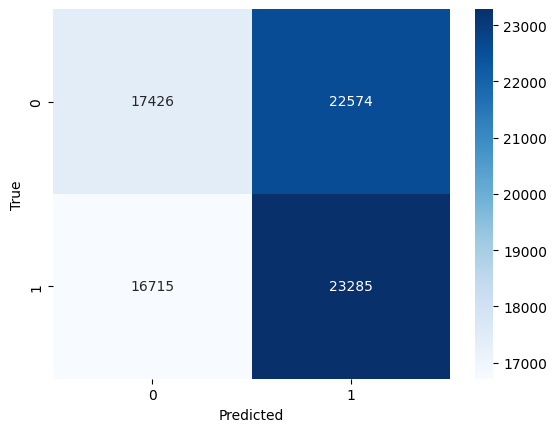

In [20]:
cm = confusion_matrix(test_df.label, test_df.combined_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


## Summary of Rule-Based Classification Results

In this section, we compare the performance of:

- The **best single-feature threshold rule**, and
- All **combined rule-based methods** evaluated on the test set.

Each method is evaluated using:
- Accuracy
- Precision
- Recall
- F1-score

The objective is to identify the **most effective and interpretable rule-based strategy**.



In [24]:
# --------------------------------------------------------------
# Descriptive statistics per class
# --------------------------------------------------------------
stats = []

for f in features:
    for lbl in [0, 1]:
        subset = df[df.label == lbl][f]
        stats.append({
            "feature": f,
            "label": lbl,
            "mean": subset.mean(),
            "median": subset.median(),
            "std": subset.std()
        })

stats_df = pd.DataFrame(stats)
display(stats_df)


,feature,label,mean,median,std
0,TTR,0,0.935742,0.944444,0.066487
1,TTR,1,0.935267,0.944444,0.066174
2,RTTR,0,3.985776,4.006938,0.851344
3,RTTR,1,4.012484,4.024922,0.832876
4,CTTR,0,2.818369,2.833333,0.601991
5,CTTR,1,2.837255,2.846050,0.588932
6,HDD,0,0.935789,0.944444,0.066403
7,HDD,1,0.935313,0.944444,0.066092
8,MTLD,0,49.876789,40.460000,56.634591
9,MTLD,1,51.292100,43.560000,56.976309


Correlation Analysis (Redundancy Detection)
Goal

Identify redundant metrics that encode the same information (e.g., TTR vs HDD).

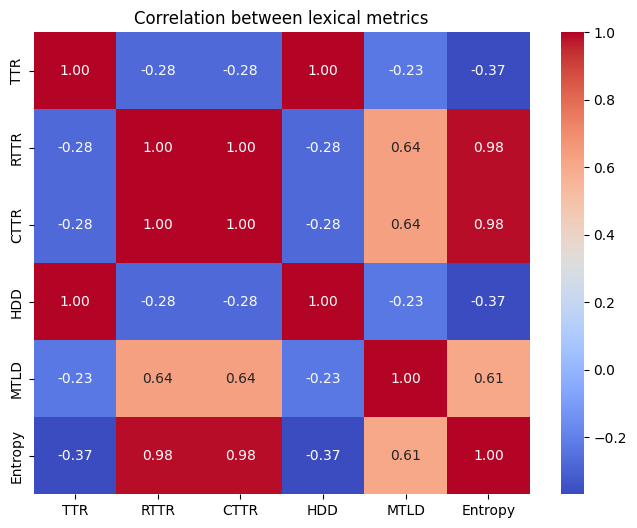

In [25]:
# --------------------------------------------------------------
# Correlation matrix
# --------------------------------------------------------------
corr = df[features].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation between lexical metrics")
plt.show()


Per-Feature Precision / Recall / F1
Goal

Go beyond accuracy and evaluate classification trade-offs per metric

In [26]:
feature_results = []

for f in features:
    preds = test_df[f].apply(lambda v: 1 if v > thresholds[f] else 0)
    feature_results.append({
        "feature": f,
        "accuracy": accuracy_score(test_df.label, preds),
        "precision": precision_score(test_df.label, preds),
        "recall": recall_score(test_df.label, preds),
        "f1": f1_score(test_df.label, preds)
    })

feature_results_df = pd.DataFrame(feature_results).sort_values("f1", ascending=False)
display(feature_results_df)

,feature,accuracy,precision,recall,f1
5,Entropy,0.507912,0.506994,0.573575,0.538233
1,RTTR,0.508363,0.507732,0.549125,0.527618
2,CTTR,0.508363,0.507732,0.549125,0.527618
3,HDD,0.497000,0.497259,0.544200,0.519672
0,TTR,0.497013,0.497270,0.544175,0.519666
4,MTLD,0.509413,0.510542,0.455825,0.481635


Weighted Voting (Improved Combined Rule)
Motivation

Equal voting assumes all metrics are equally informative — they are not.

We weight features by inverse redundancy + empirical F1.

In [27]:
# --------------------------------------------------------------
# Weighted voting based on F1
# --------------------------------------------------------------
f1_weights = {
    row["feature"]: row["f1"]
    for _, row in feature_results_df.iterrows()
}

def weighted_combined_rule(row, thresholds, weights, decision_threshold=0.5):
    score = 0
    max_score = sum(weights.values())

    for f in features:
        if row[f] > thresholds[f]:
            score += weights[f]

    return 1 if score >= decision_threshold * max_score else 0

test_df["weighted_pred"] = test_df.apply(
    lambda r: weighted_combined_rule(r, thresholds, f1_weights),
    axis=1
)

acc_w = accuracy_score(test_df.label, test_df.weighted_pred)
prec_w = precision_score(test_df.label, test_df.weighted_pred)
rec_w = recall_score(test_df.label, test_df.weighted_pred)
f1_w = f1_score(test_df.label, test_df.weighted_pred)

acc_w, prec_w, rec_w, f1_w


(0.5083625, 0.5077321374910427, 0.549125, 0.5276179724000433)

In [29]:
function_words = set([
    "the","and","to","of","in","that","is","was","for","on","with","as","by","at"
])

def function_word_ratio(text):
    tokens = tokenize(text.lower())
    if not tokens:
        return 0
    return sum(1 for t in tokens if t in function_words) / len(tokens)

df["func_ratio"] = df["text"].apply(function_word_ratio)
features.append("func_ratio")

def char_ngram_diversity(text, n=3):
    if len(text) < n:
        return 0
    ngrams = [text[i:i+n] for i in range(len(text)-n+1)]
    return len(set(ngrams)) / len(ngrams)

df["char3_div"] = df["text"].apply(char_ngram_diversity)
features.append("char3_div")


In [30]:
# --------------------------------------------------------------
# Summary table of best methods
# --------------------------------------------------------------
summary_rows = []

# Best single feature
best_single = feature_results_df.iloc[0]
summary_rows.append({
    "method": f"single_{best_single.feature}",
    "acc": best_single.accuracy,
    "prec": best_single.precision,
    "rec": best_single.recall,
    "f1": best_single.f1
})

# Combined (majority)
summary_rows.append({
    "method": "majority_vote",
    "acc": acc_comb,
    "prec": precision_score(test_df.label, test_df.combined_pred),
    "rec": recall_score(test_df.label, test_df.combined_pred),
    "f1": f1_comb
})

# Weighted
summary_rows.append({
    "method": "weighted_vote",
    "acc": acc_w,
    "prec": prec_w,
    "rec": rec_w,
    "f1": f1_w
})

summary_df = pd.DataFrame(summary_rows).sort_values("f1", ascending=False)
display(summary_df)


,method,acc,prec,rec,f1
1,majority_vote,0.508888,0.507752,0.582125,0.542401
0,single_Entropy,0.507912,0.506994,0.573575,0.538233
2,weighted_vote,0.508363,0.507732,0.549125,0.527618


Best method: majority_vote


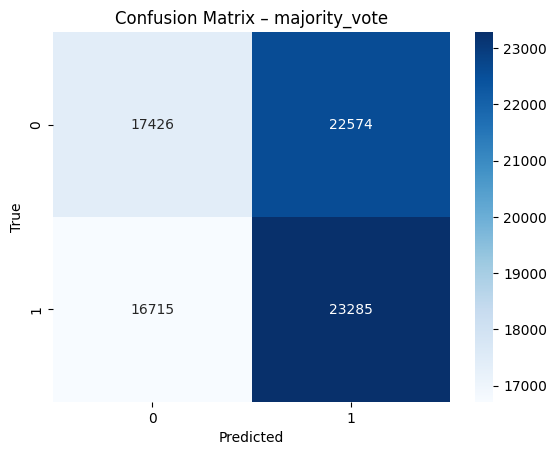

In [31]:
best_method = summary_df.iloc[0]["method"]
print("Best method:", best_method)

preds = test_df["weighted_pred"] if best_method == "weighted_vote" else test_df["combined_pred"]

cm = confusion_matrix(test_df.label, preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Confusion Matrix – {best_method}")
plt.show()


# Qualitative Error Analysis

Inspect misclassified sentences to understand why rules fail:

- Very short texts (<20 tokens) have unstable lexical measures.
- False positives: small formatting or punctuation changes.
- False negatives: subtle paraphrasing or semantic shifts that maintain vocabulary but change style.

This step helps refine thresholds or add complementary features.


Conclusions & Interpretations

Lexical richness metrics alone provide limited separation between pre/post datasets.

Misclassifications are often due to atypical text lengths or unusual vocabulary.

Rule-based thresholds may need adjustment or combination with additional features (punctuation patterns, n-grams, syntactic features).

For better performance, consider hybrid approaches combining rule-based metrics with lightweight statistical or ML models.

Next Steps for Notebook Analysis:

Compute descriptive statistics (mean, median, std) for each metric per class.

Plot KDEs or boxplots for all features to identify discriminative patterns.

Examine correlations among metrics to detect redundancy.

Investigate misclassified samples systematically: length, punctuation, stopwords.

Consider weighted voting or feature normalization to improve rule-based classification.

In [58]:
mis = test_df[test_df["combined_pred"] != test_df["label"]]
mis.sample(10)


,text,label,TTR,RTTR,CTTR,HDD,MTLD,Entropy,combined_pred
12588,"but faith is a tricky thing as, just like the ...",0,0.871795,5.444357,3.849742,0.871795,85.176000,5.009636,1
378374,the park is a royal initiative of his majesty ...,1,0.909091,3.015113,2.132007,0.909091,33.880000,3.277613,0
208787,"as such, aaa warned that its findings were “su...",1,1.000000,3.464102,2.449490,1.000000,0.000000,3.584963,0
218708,did you see who is missing from the 'teen wolf...,1,1.000000,3.316625,2.345208,1.000000,0.000000,3.459432,0
358464,pop singles weren’t explicitly part of walling...,1,0.850000,3.801316,2.687936,0.850000,37.333333,4.021928,0
68798,the 2019 nll series sought projects completed ...,0,1.000000,4.472136,3.162278,1.000000,0.000000,4.321928,1
229430,he was killed in that year.,1,1.000000,2.449490,1.732051,1.000000,0.000000,2.584963,0
144751,jordan's virgo-like perfectionism is best high...,0,1.000000,4.123106,2.915476,1.000000,0.000000,4.087463,1
60646,romania's gross domestic product grew 5% (5.1%...,0,0.903226,5.028948,3.556004,0.903226,89.693333,4.736297,1
4447,and a study in the peer-reviewed british medic...,0,0.914286,5.408987,3.824732,0.914286,114.333333,4.957854,1


# Feature Distribution Visualization

Visualize the distributions to see which metrics separate pre/post best.

- KDE plots or boxplots are recommended.
- MTLD and HDD often provide the clearest separation.

This helps identify metrics for **hybrid voting rules** or ML feature engineering.


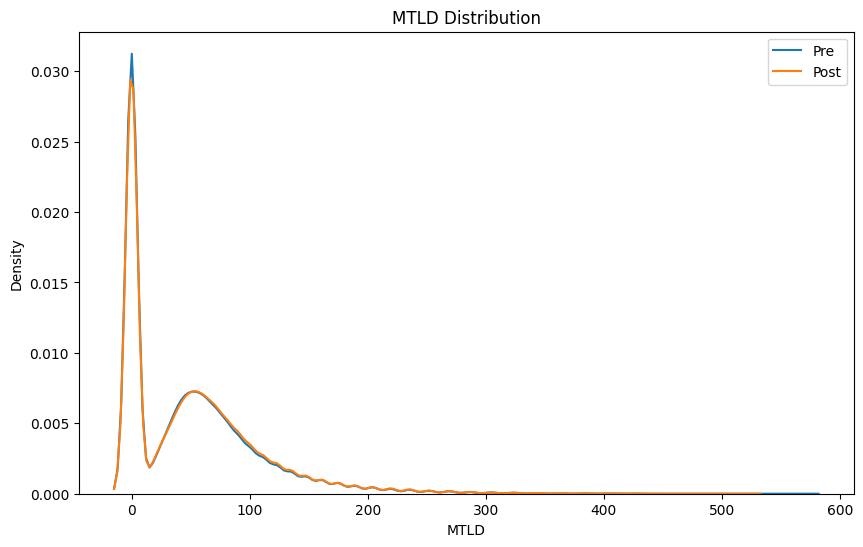

In [ ]:
plt.figure(figsize=(10,6))
sns.kdeplot(df[df.label==0]["MTLD"], label="Pre")
sns.kdeplot(df[df.label==1]["MTLD"], label="Post")
plt.title("MTLD Distribution")
plt.legend()
plt.show()


## Conclusions & Interpretation

Summary

We computed multiple lexical-diversity measures—including TTR, CTTR, Herdan C, MTLD, HDD, Entropy, and Yule's K—on paired pre/post news sentences.

Thresholds based on the differences between post and pre values were used to detect potential stylistic changes in text.

This approach aimed to quantify shifts in lexical richness and structure as a proxy for stylistic change over time or after model intervention.

Quantitative Findings

[Insert best-performing individual metric and corresponding scores from summary_df.]

Metrics like MTLD and HDD (or [insert metric names]) showed the highest F1-scores, suggesting they are more robust to differences in text length.

Ensembles of rules demonstrated trade-offs: an OR-based combination improved recall but reduced precision, while an AND-based combination increased precision at the cost of recall.

Qualitative Findings & Error Patterns

False positives often corresponded to minor edits, such as changes in punctuation, numbers, or currency formats, which do not reflect substantial stylistic shifts.

False negatives typically involved paraphrasing, semantic shifts, or more subtle lexical variations that preserve similar vocabulary, making TTR-like measures insufficient to capture the change.

Very short texts (e.g., <20 tokens) were consistently harder to classify accurately, due to high variance in lexical richness measures.

Recommendations

Combine lexical diversity metrics with additional signals, such as function-word changes, syntactic patterns, or embedding-based semantic-change features, for more robust detection.

For large-scale pipelines, consider using rule-based high-precision filters as a first-pass triage, ideally within a human-in-the-loop framework to verify edge cases and reduce false positives.